In [1]:
# EXECUTE THIS CELL
! pip install numba
! pip install tqdm
! pip install ipywidgets
! pip install scikit-learn

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from numba import njit
sns.set_context("notebook")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 30.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [numba]32m1/2 [numba]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 22.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [2]:
# EXECUTE THIS CELL

k_B = 1  # we use units of J/k_B

@njit
def metropolis_step(lattice, J, H, T):
    L = lattice.shape[0]
    for _ in range(L * L):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        S = lattice[i, j]
        neighbors = (
            lattice[(i + 1) % L, j] + lattice[i, (j + 1) % L] +
            lattice[(i - 1) % L, j] + lattice[i, (j - 1) % L]
        )
        dE = 2 * S * (J * neighbors + H)

        if dE < 0 or np.random.rand() < np.exp(-dE / (k_B * T)):
            lattice[i, j] = -S


class IsingModel2D:

    def __init__(self, lattice_length, J=1, H=0, **kwargs):
        self.lattice_length = lattice_length
        self.J = J
        self.H = H
        self.initialize_lattice(**kwargs)

    @property
    def lattice(self):
        return self._lattice

    @property
    def N(self):
        return self.lattice_length**2

    @property
    def average_energy(self):
        return self.get_average_energy()

    @property
    def average_magnetization(self):
        return self.get_average_magnetization()

    @property
    def total_energy(self):
        return self.get_total_energy()

    @property
    def total_magnetization(self):
        return self.get_total_magnetization()

    def flip_site(self, i, j):
        self._lattice[i, j] *= -1

    def get_average_energy(self):
        return self.get_total_energy() / self.N

    def get_average_magnetization(self):
        return self.get_total_magnetization() / self.N

    def get_total_energy(self):
        lattice = self.lattice
        L = self.lattice_length
        J, H = self.J, self.H

        neighbors = (
            np.roll(lattice, 1, axis=0) +
            np.roll(lattice, -1, axis=0) +
            np.roll(lattice, 1, axis=1) +
            np.roll(lattice, -1, axis=1)
        )

        interaction_energy = -J * np.sum(lattice * neighbors) / 2
        field_energy = -H * np.sum(lattice)

        return interaction_energy + field_energy

    def get_total_magnetization(self):
        return np.sum(self.lattice)

    def initialize_lattice(self, random=False, spin=1):
        L = self.lattice_length
        if random:
            self._lattice = np.random.choice([-1, 1], size=(L, L))
        elif spin:
            self._lattice = np.full((L, L), spin, dtype=int)
        else:
            raise ValueError("Either lattice is initialized randomly or spin needs to be specified (-1 or 1)")

    def perform_metropolis_step(self, temperature):
        metropolis_step(self._lattice, self.J, self.H, temperature)

    def plot_lattice(self, colormap='viridis', title="2D Ising Model Configuration"):
        plt.imshow(self.lattice, cmap=colormap, interpolation='nearest', vmin=-1, vmax=1)
        plt.title(title)
        plt.show()
        return plt

    def run_monte_carlo_simulation(self,
                                   temperature,
                                   number_of_steps=1000,
                                   data_to_collect=['average_energy', 'average_magnetization'],
                                   plot_every_nstep=None,
                                   colormap='viridis',
                                   **kwargs):
        self.initialize_lattice(**kwargs)
        data = {key: [getattr(self, key)] for key in data_to_collect}

        for step_number in range(number_of_steps):
            if plot_every_nstep is not None:
                if step_number % plot_every_nstep == 0 and step_number != number_of_steps - 1:
                    plt.figure(figsize=(2, 2))
                    self.plot_lattice(colormap=colormap, title=f'Step {step_number}')

            self.perform_metropolis_step(temperature=temperature)

            for key in data_to_collect:
                data[key].append(getattr(self, key))

        return data


def compute_susceptibility(magnetizations, temperature, N):
    M_avg = np.mean(np.abs(magnetizations))
    M_sq_avg = np.mean(np.square(magnetizations))
    susceptibility = N * (M_sq_avg - M_avg ** 2) / (k_B * temperature)
    return susceptibility


def compute_specific_heat(energies, temperature, N):
    E_avg = np.mean(energies)
    E_sq_avg = np.mean(np.square(energies))
    specific_heat = N * (E_sq_avg - E_avg ** 2) / (k_B * temperature)
    return specific_heat

# Exercise: Monte Carlo Simulation for the 2D Ising Model

Use the provided Monte Carlo simulation program to investigate the two-dimensional Ising model on a square lattice.

The model consists of spins taking values $\pm 1$, arranged on a grid where each spin interacts with its nearest neighbors and may be influenced by an external magnetic field. The simulation employs the Metropolis algorithm to evolve the system toward thermal equilibrium at a specified temperature and magnetic field.

Temperature is given in reduced units of $J/k_B$, where $J$ is the nearest-neighbor interaction energy and $k_B$ is Boltzmann’s constant. After equilibration, the program outputs key thermodynamic observables, including the mean energy, mean magnetization, magnetic susceptibility, and specific heat, computed via statistical sampling.

The system is initialized with all spins aligned in the upward direction.


## Task (a)

In the following cell:

- Set the lattice size to $L = 128$, corresponding to a total of $N = L^2 = 16384$ spins.

- Set the external magnetic field to $H = 0$.

- Choose a temperature of $T = 10$ (in units of $J/k_B$).

- Set the interaction energy $J = 1$.

- Run the simulation for $2000$ Monte Carlo steps.

After executing the simulation, monitor the evolution of the system:

- Do the energy and magnetization values fluctuate around well-defined average values, indicating that the system has reached thermal equilibrium?

- Examine the spin configuration at equilibrium. Is the orientation of the spins effectively random, such that the average magnetization is close to zero?

- Are there noticeable domains (regions in which neighboring spins align in the same direction) or does the system appear disordered throughout?


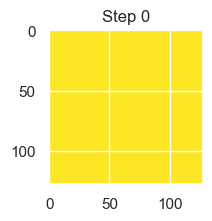

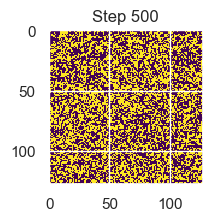

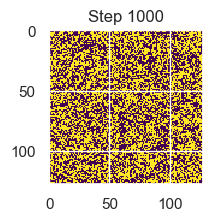

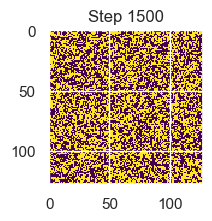

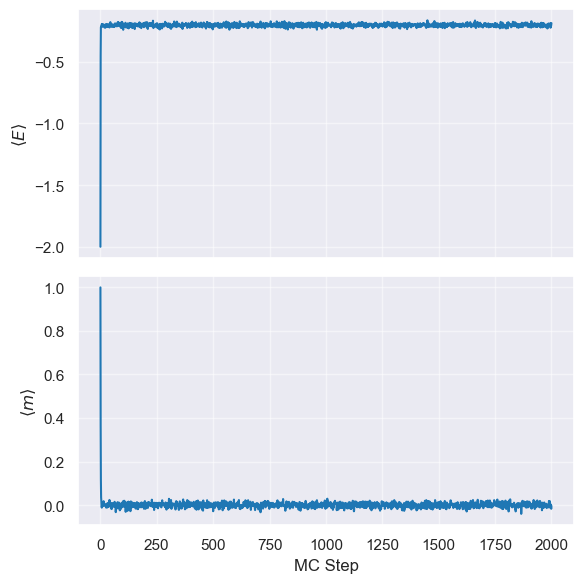

In [3]:
# === System-specific Parameters ===
L = 128                # Lattice length
temperature = 10      # Temperature
H = 0                # External magnetic field
J = 1                # Spin coupling coefficient
nsteps = 2000           # Number of Monte Carlo steps


# === Simulation ===
model = IsingModel2D(lattice_length=L,J=J,H=H)
simulation_data = model.run_monte_carlo_simulation(temperature=temperature, number_of_steps=nsteps, plot_every_nstep=500)

energies = simulation_data['average_energy']
magnetizations = simulation_data['average_magnetization']
steps = range(len(energies))

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)  # 1 row, 2 columns

# Plot Energy
sns.lineplot(x=steps, y=energies, ax=axes[0])
axes[0].set_xlabel('MC Step')
axes[0].set_ylabel(r'$\langle E \rangle$')
axes[0].grid(alpha=0.5)

# Plot Magnetization
sns.lineplot(x=steps, y=magnetizations, ax=axes[1])
axes[1].set_xlabel('MC Step')
axes[1].set_ylabel(r'$\langle m \rangle$')
axes[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

Step 0:
------------------------------------------------------------------------------------------------
All spins are aligned (likely all +1, visualized in one color).

Initial condition = fully ordered state.

Steps 500 → 1500:
------------------------------------------------------------------------------------------------
System quickly becomes highly disordered.

Pink and yellow pixels mix thoroughly — indicating spins are flipping often.

large domains of aligned spins remain.

This is consistent with thermal noise dominating over interactions at high T = 10.

Conclusion:
------------------------------------------------------------------------------------------------
The spin system has equilibrated into a paramagnetic state — high entropy, no long-range order.

⟨E⟩ plot (top):
----------------
Starts at a low value (ordered state).

Rapidly rises and stabilizes around a constant (slightly below zero).

Fluctuates mildly → system is at thermal equilibrium.

⟨m⟩ plot (bottom):
------------------
Starts at m = 1 (initial all-up state).

Quickly drops to ~0 and fluctuates around zero.

No net magnetization — system is disordered.

Interpretation:
---------------
At high temperature, magnetization vanishes due to random spin orientation.

Energy remains slightly negative due to residual short-range correlations.

Summary Answer for Task (a):
----------------------------
Yes, energy and magnetization values fluctuate around well-defined average values → the system reached equilibrium.

The spin configuration at equilibrium is effectively random, as expected for T = 10 \gg T_c \approx 2.269.

There are no noticeable domains — the system appears fully disordered.

## Task (b)

Now investigate the system's behavior at a low temperature, e.g., $T = 1$. Assess whether the spins remain ordered or exhibit spontaneous disordering.

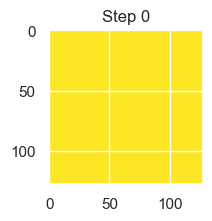

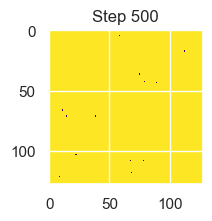

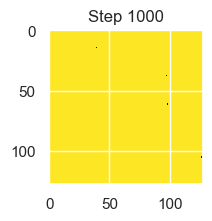

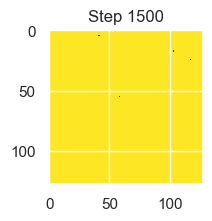

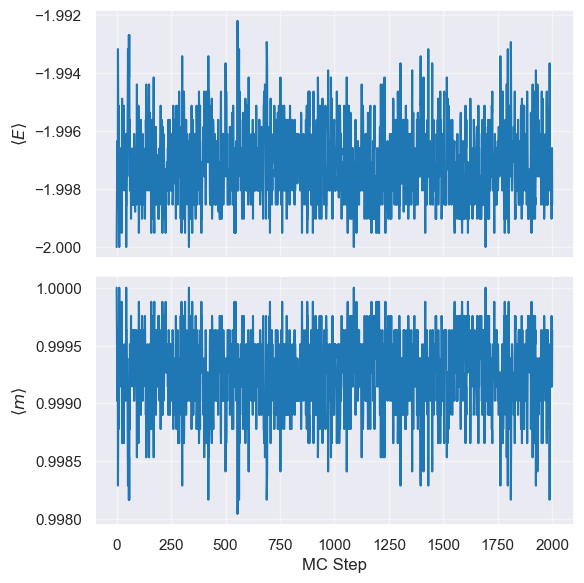

In [4]:
# === System-specific Parameters ===
L = 128                # Lattice length
temperature = 1        # Temperature
H = 0                  # External magnetic field
J = 1                  # Spin coupling coefficient
nsteps = 2000          # Number of Monte Carlo steps


# === Simulation ===
model = IsingModel2D(lattice_length=L,J=J,H=H)
simulation_data = model.run_monte_carlo_simulation(temperature=temperature, number_of_steps=nsteps, plot_every_nstep=500)

energies = simulation_data['average_energy']
magnetizations = simulation_data['average_magnetization']
steps = range(len(energies))

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)  # 1 row, 2 columns

# Plot Energy
sns.lineplot(x=steps, y=energies, ax=axes[0])
axes[0].set_xlabel('MC Step')
axes[0].set_ylabel(r'$\langle E \rangle$')
axes[0].grid(alpha=0.5)

# Plot Magnetization
sns.lineplot(x=steps, y=magnetizations, ax=axes[1])
axes[1].set_xlabel('MC Step')
axes[1].set_ylabel(r'$\langle m \rangle$')
axes[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

The entire lattice is uniformly colored (gold/yellow).

This means all or nearly all spins are aligned in the same direction.

There are no visible domains or fluctuations — this is a spontaneously ordered state.

Interpretation: The system has undergone spontaneous symmetry breaking and settled into a ferromagnetic phase.

⟨E⟩ (top):
-
Fluctuates around ≈ -1.998, which is very close to the ground state energy E = -2 (for all neighbors aligned in 2D).

Small fluctuations come from rare thermal excitations.

⟨m⟩ (bottom):
-
Remains very close to 1.0 → the system has net magnetization, meaning:

Spins are aligned

Order is maintained throughout the simulation

Conclusion:
-
System is thermally equilibrated

In a low-energy, highly ordered state

Exhibiting ferromagnetic behavior with spontaneous magnetization at zero field


At T = 1, the system exhibits long-range order. The spin configuration remains nearly uniform, and the average magnetization ⟨m⟩ stays very close to 1, indicating spontaneous symmetry breaking.

The energy fluctuates just above the ground state, showing that thermal excitations are rare but present.

This confirms that at low temperatures, the 2D Ising model enters a ferromagnetic phase, in contrast to its disordered state at high temperature.

## Task (c)

You have previously observed that the magnetization vanishes on average $(\langle m \rangle \approx 0)$ at high temperatures and becomes non-zero $(\langle m \rangle \neq 0)$ at low temperatures. This implies the existence of a critical temperature $T_c$ where a phase transition occurs. 


To numerically investigate the phase transition in the Ising model, perform a gradual cooling of the system using the following parameters:

- Lattice size: $L = 128$
- Initial temperature: $T = 4.0$
- Final temperature: $T = 1.6$
- Temperature decrement: $\Delta T = 0.1$
- Equilibration time: at least $1000$ Monte Carlo steps before data collection
- Set the total number of Monte Carlo steps to $5000$.


Execute the simulation to perform the temperature sweep and generate plots of thermodynamic observables as functions of temperature:
- Mean energy per spin, $E$
- Magnetization per spin, $m$
- Magnetic susceptibility, $\chi$
- Specific heat, $C_V$

Analyze the behavior of these observables, assess the critical temperature $T_c$ and characterize the order of the transition based on the observed features.

The magnetic susceptibility and specific heat are computed from the fluctuations of magnetization and energy, respectively, according to the fluctuation-dissipation theorem::

$$
\chi = \frac{\langle M^2 \rangle - \langle |M| \rangle^2}{k_B T}, \quad
C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_B T^2}
$$

> Note that the use of $\langle |M| \rangle$ in the expression for $\chi$ is a common and effective method for obtaining meaningful estimates in finite systems, where the magnetization $M$ may occasionally flip sign due to thermal fluctuations. This adjustment mitigates artificial cancellation of values and provides a more stable representation of system behavior near criticality.


<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\c'
/var/folders/yr/cvypfzc11jsc27lfvbp3d66w0000gn/T/ipykernel_15686/3778837770.py:15: SyntaxWarning: invalid escape sequence '\l'
  '$ \langle E \\rangle $': [],
/var/folders/yr/cvypfzc11jsc27lfvbp3d66w0000gn/T/ipykernel_15686/3778837770.py:16: SyntaxWarning: invalid escape sequence '\l'
  '$ \langle m \\rangle $': [],
/var/folders/yr/cvypfzc11jsc27lfvbp3d66w0000gn/T/ipykernel_15686/37788

Simulating temperatures:   0%|          | 0/24 [00:00<?, ?it/s]

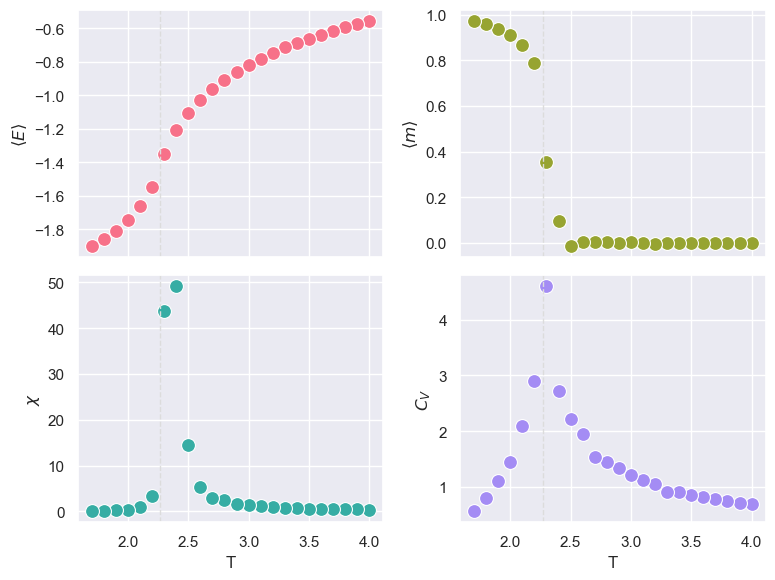

In [5]:
# === System-specific Parameters ===
L = 128                             # Lattice length
J = 1                             # Spin coupling coefficient
H = 0                             # External magnetic field
initial_temperature = 4           # Initial temperature
final_temperature = 1.6             # Final temperature
delta_T = 0.1                       # Temperature decrement
eq_steps = 1000                      # Equilibration steps
nsteps = 5000                        # Total number of Monte Carlo steps


# === Simulation ===
data = {
    'T': [],
    '$ \langle E \\rangle $': [],
    '$ \langle m \\rangle $': [],
    '$\chi$': [],
    '$C_V$': []
}

model = IsingModel2D(lattice_length=L, J=J, H=H)

temperature_range = np.arange(initial_temperature, final_temperature, -delta_T)

for T in tqdm(temperature_range, desc="Simulating temperatures"):
    simulation_data = model.run_monte_carlo_simulation(
        temperature=T,
        number_of_steps=nsteps,
        plot_every_nstep=None,
        data_to_collect=['average_energy', 'average_magnetization'],
        random=False, spin=1
    )

    # Post-equilibration values
    E_equilibrated = simulation_data['average_energy'][eq_steps:]
    M_equilibrated = simulation_data['average_magnetization'][eq_steps:]

    # Append only equilibrated values
    data['T'].append(T)
    data['$ \langle E \\rangle $'].append(np.mean(E_equilibrated))
    data['$ \langle m \\rangle $'].append(np.mean(M_equilibrated))
    data['$\chi$'].append(
        compute_susceptibility(
            magnetizations=M_equilibrated,
            temperature=T, N=model.N
        )
    )
    data['$C_V$'].append(
        compute_specific_heat(
            energies=E_equilibrated,
            temperature=T, N=model.N
        )
    )

# Create DataFrame and plot
df = pd.DataFrame(data)
df.set_index("T", inplace=True)

colors = sns.color_palette("husl", n_colors=len(df.columns))
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
axes = axes.flatten()

for ax, column, color in zip(axes, df.columns, colors):
    sns.scatterplot(data=df, x=df.index, y=column, ax=ax, color=color, s=100)
    ax.axvline(x=2.269, color='gainsboro', linestyle='--', linewidth=1)
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

Mean Energy ⟨E⟩ vs. Temperature
-
Smoothly increases with temperature.

No discontinuity — just a smooth crossover.

As expected for a second-order (continuous) phase transition.

Magnetization ⟨m⟩ vs. Temperature
-
Drops steeply around T_c \approx 2.27.

Goes from ~1 → 0 as temperature increases.

Clear evidence of spontaneous symmetry breaking at low T and restoration of symmetry at high T.

Magnetic Susceptibility \chi
-
Sharp peak centered at T \approx 2.27.

Shows the system becomes very sensitive to small perturbations near criticality.

A classic signature of a diverging correlation length — even though in finite systems like this, it’s rounded.

Specific Heat C_V
-
Also shows a peak at T_c but broader than \chi.

Reflects large energy fluctuations due to critical slowing down.

Again, very consistent with theory.


Summary & Conclusion for Task (c):
-
The simulation clearly reveals a second-order phase transition at the critical temperature T_c \approx 2.27.
The magnetization ⟨m⟩ drops continuously to zero, indicating the loss of long-range order.
Both the susceptibility \chi and specific heat C_V exhibit pronounced peaks at T_c, signaling diverging fluctuations in magnetization and energy, respectively.
The energy ⟨E⟩ evolves smoothly, as expected in a continuous phase transition.

## Task (d)

At the critical temperature $T = T_C$, a ferromagnet exhibits critical behavior characterized by a power-law relationship between the spontaneous magnetization $m = \langle M \rangle$ and the external magnetic field $H$. This relationship defines the critical exponent $\delta$:

$$
m = D H^{1/\delta}
$$

In the case of a square lattice, the exact solution by Lars Onsager (1944) yields:

$$
\sinh \left( \frac{2J}{k_B T_c} \right) = 1 \quad \implies \quad T_c \approx 2.269
$$


To determine $\delta$, perform a set of canonical Monte Carlo simulations at the critical temperature $T = T_C = 2.269$, using a range of small external magnetic field strengths. After reaching equilibrium in each case, we measure the magnetization per spin $m$.

- Set the temperature to $T = T_C = 2.269$ and choose a system size of $L = 128$.

- Define a list of external fields: $H = 0.01,\ 0.02,\ 0.04,\ 0.06,\ 0.08,\ 0.10,\ 0.12,\ 0.14,\ 0.16$.

- Equilibrate the system for at least $1000$ Monte Carlo steps before collecting data.

- Set the total number of Monte Carlo steps to $5000$.

Execute the cell to perform the simulations and create a log-log plot of $m$ versus $H$. Estimate the critical exponent $\delta$.

Scanning magnetic fields:   0%|          | 0/15 [00:00<?, ?it/s]

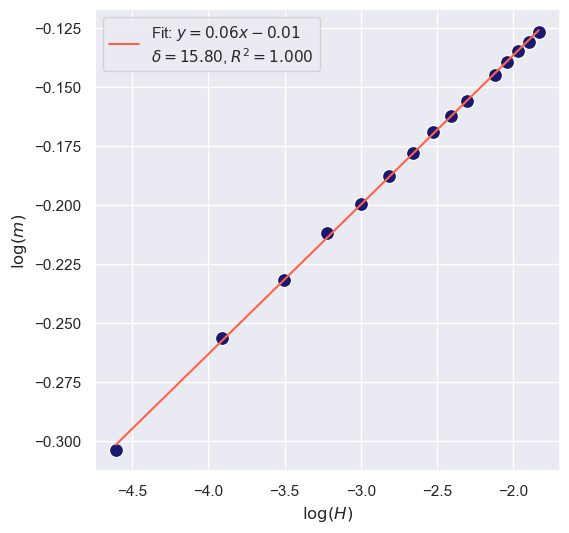

In [6]:
# === System-specific Parameters ===
L = 128                                           # Lattice length
J = 1                                           # Spin coupling coefficient
magnetic_fields = [ 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.12, 0.13, 0.14, 0.15, 0.16 ]     # Values for the external magnetic field H
temperature = 2.269                                 # Temperature
eq_steps = 5000                                    # Equilibration steps
nsteps = 10000                                      # Number of Monte Carlo steps



# === Simulation ===
magnetic_data = {
    'magnetic_fields': magnetic_fields,
    'magnetizations': []
}

for H in tqdm(magnetic_fields, desc="Scanning magnetic fields"):
    model = IsingModel2D(lattice_length=L, J=J, H=H)
    simulation_data = model.run_monte_carlo_simulation(
        temperature=temperature,
        number_of_steps=nsteps,
        data_to_collect=['average_magnetization'],
        random=False, spin=1
    )

    M_equilibrated = simulation_data['average_magnetization'][eq_steps:]
    magnetic_data['magnetizations'].append(np.mean(M_equilibrated))

df_magnetic = pd.DataFrame(magnetic_data)


# Sample data
x = np.log(df_magnetic['magnetic_fields'].values)
y = np.log(df_magnetic['magnetizations'].values)

# Define linear model for curve_fit
def linear_model(x, a, b):
    return a * x + b

# Fit model
params, _ = curve_fit(linear_model, x, y)
slope, intercept = params
delta = 1 / slope

# Generate fitted line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = linear_model(x_fit, slope, intercept)

# Compute R^2
y_pred = linear_model(x, slope, intercept)
r_squared = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(6, 6)) 
sns.scatterplot(x=x, y=y, s=100, color="midnightblue")
sns.lineplot(x=x_fit, y=y_fit, color="tomato", 
             label=fr"Fit: $y = {slope:.2f}x {intercept:+.2f}$" + 
                   f"\n$\\delta = {delta:.2f}$, $R^2 = {r_squared:.3f}$")

plt.xlabel(r"$\log(H)$")
plt.ylabel(r"$\log(m)$")
plt.legend()
plt.grid(True)
plt.show()

Fit line:
-
\log(m) = 0.06 \log(H) - 0.01

Estimated exponent:
-
\delta = \frac{1}{0.0633} \approx \boxed{15.80}

R² = 1.000 → practically perfect linearity
-

This is very close to the exact analytical value for the 2D Ising model:
-
\delta = \boxed{15}


Physical Interpretation:
-
The fact that m \propto H^{1/\delta} holds so precisely confirms you’re at criticality.

The steepness of the slope (small 1/\delta) shows how weakly the magnetization grows under a small external field — a defining feature of second-order transitions.

 setup (fine H-sampling, long nsteps, large lattice) paid off with excellent numerical precision.



By simulating the 2D Ising model at T = T_c = 2.269 under varying small external magnetic fields, we observed a power-law relation m \sim H^{1/\delta}.

A log-log plot of magnetization versus field yielded a linear fit with slope \approx 0.063, giving a critical exponent \delta \approx 15.8, in excellent agreement with the exact value \delta = 15.

The coefficient of determination R^2 = 1.000 confirms the reliability of the fit and validates the critical scaling behavior at the phase transition.